In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

torchvision의 transforms를 활용하여 정규화를 적용할 수 있습니다.

transoforms.ToTensor() 외 다른 Normalize()를 적용하지 않은 경우

정규화(Normalize) 한 결과가 0 ~ 1 범위로 변환됩니다.


In [2]:
transform = transforms.Compose([
    # 0~1의 범위를 가지도록 정규화
    transforms.ToTensor(),
])

# Case 1. 내장(built-in) 데이터셋 로드 : FashionMNIST 데이터

- FashionMNIST 데이터셋 로드하는 예제
- root: 데이터셋을 다운로드 받을 경로(폴더) 지정.
- train: True로 설정된 경우 train 데이터셋에서 로드하며, False인 경우 test 데이터셋에서 로드
- download: True로 설정된 경우, 인터넷으로부터 데이터셋을 다운로드 받아 지정된 root 디렉토리에 다운로드
- transform: 이미지 transform 적용

In [3]:
# train(학습용) 데이터셋 로드
train = datasets.FashionMNIST(root='data',
                              train=True,         # set True
                              download=True,      # 다운로드
                              transform=transform # transform 적용. (0~1 로 정규화)
                             )

100%|██████████| 26421880/26421880 [00:02<00:00, 13120475.03it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208881.87it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3952708.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3311698.93it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# test(학습용) 데이터셋 로드
test = datasets.FashionMNIST(root='data',
                             train=False,       # set to False
                             download=True,     # 다운로드
                             transform=transform # transform 적용. (0~1 로 정규화)
                            )

FashionMNIST 데이터셋 시각화

총 10개의 카테고리로 구성되어 있으며, Label은 아래 코드에서 labels_map에 정의되어 있습니다.

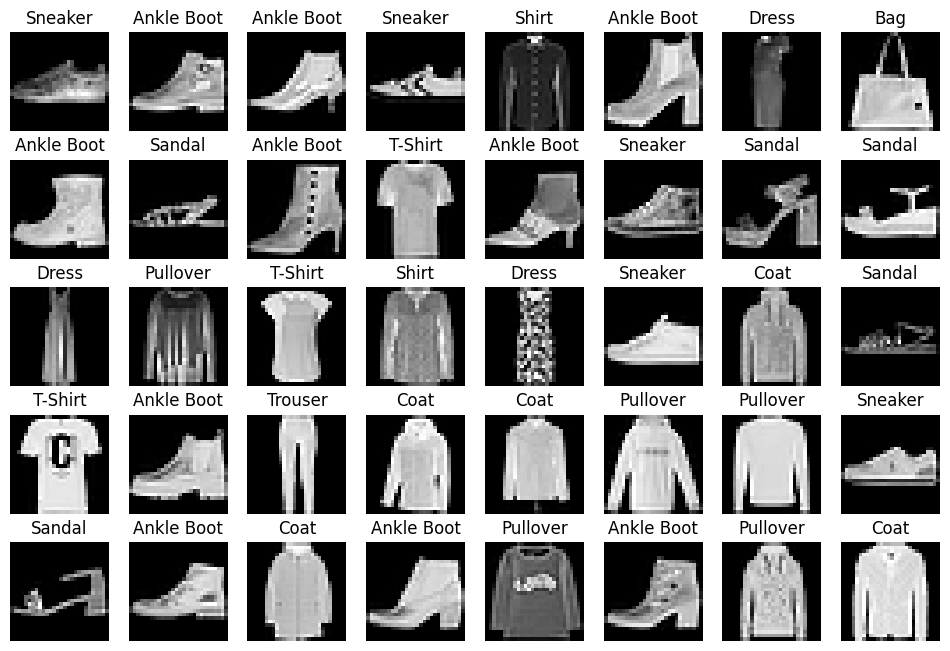

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

## 흑백 이미지 통계량 확인 함수

In [8]:
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()

    print(f'min: {min_r}')
    print(f'max: {max_r}')
    print(f'mean: {mean_r}')
    print(f'std: {std_r}')

In [9]:
print_stats(train)
print('==='*10)
print_stats(test)

shape: (60000, 1, 28, 28)
min: 0.0
max: 1.0
mean: 0.28604063391685486
std: 0.0785854160785675
shape: (10000, 1, 28, 28)
min: 0.0
max: 1.0
mean: 0.28684931993484497
std: 0.07803065329790115


transforms.ToTensor()만 적용한 경우, 모든 이미지의 픽셀 값이 0~1의 범위를 가지도록 변환되었습니다.



Gray scale( 흑백 이미지) 이기 때문에 함수를 다르게 정의했다.

In [10]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [11]:
train_loader = torch.utils.data.DataLoader(train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)

# Case 2. 로컬 디렉토리에서 Image를 로드 : 가위바위보 이미지

images 폴더에 rps 데이터셋 다운로드

In [13]:
# 이미지 데이터셋 다운로드
import urllib.request
import zipfile
import glob

url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('images/')
zip_ref.close()

print(glob.glob('images/rps/*'))

['images/rps/scissors', 'images/rps/rock', 'images/rps/paper']


다운로드 받은 이미지는 images폴더 하위에 rps 폴더에 rock, paper, scissors 폴더가 생성되었으며, 각각의 폴더 밑에 가위/바위/보자기 사진 파일이 위치해 있습니다.

In [14]:
# rock 폴더 하위에 위치한 .png 파일 10개 출력
glob.glob('images/rps/rock/*')[:10]

['images/rps/rock/rock03-062.png',
 'images/rps/rock/rock05ck01-064.png',
 'images/rps/rock/rock01-097.png',
 'images/rps/rock/rock07-k03-052.png',
 'images/rps/rock/rock01-046.png',
 'images/rps/rock/rock06ck02-025.png',
 'images/rps/rock/rock02-080.png',
 'images/rps/rock/rock05ck01-050.png',
 'images/rps/rock/rock02-051.png',
 'images/rps/rock/rock06ck02-057.png']

현재 root 디렉토리는 images/rps 폴더가 root 디렉토리입니다.

간단히 도식화 해보면 다음과 같습니다.

images/rps
rock 폴더
paper 폴더
scissor 폴더

In [15]:
image_folder = datasets.ImageFolder(root='images/rps',
                                    transform=transforms.Compose([
                                        transforms.ToTensor(),
                                    ])
                                   )

image_folder 변수에 class_to_idx 속성 값을 확인해보면 class에 맵핑되는 label을 확인할 수 있습니다.

In [16]:
# class to index 라벨값 확인 (추후 시각화에 활용)
image_folder.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [17]:
train_loader = torch.utils.data.DataLoader(image_folder,         # image_folder를 지정
                                           batch_size=batch_size,# 배치사이즈 지정
                                           shuffle=True,        # shuffle 여부 지정
                                           num_workers=8)       # num_workers 지정

In [18]:
test_loader = torch.utils.data.DataLoader(image_folder,          # 원래는 별도의 Validation Set의 root 경로를 지정해야 한다.
                                          batch_size=batch_size, # 배치사이즈 지정
                                          shuffle=False,        # shuffle 여부 지정
                                          num_workers=8)         # num_workers 지정

1개의 배치(Batch)를 가져와서 shape를 확인하고, 시각화를 해봅니다.

In [19]:
# 1개 batch 추출
images, labels = next(iter(train_loader))

In [20]:
# images, labels에 각각 32개의 batch가 로드되어 있습니다.
# images는 300 X 300 사이즈 RGB 이미지 32장이 1개 batch로 구성되어 있습니다.
images.shape, labels.shape

(torch.Size([32, 3, 300, 300]), torch.Size([32]))

RPS 데이터셋을 시각화 합니다.

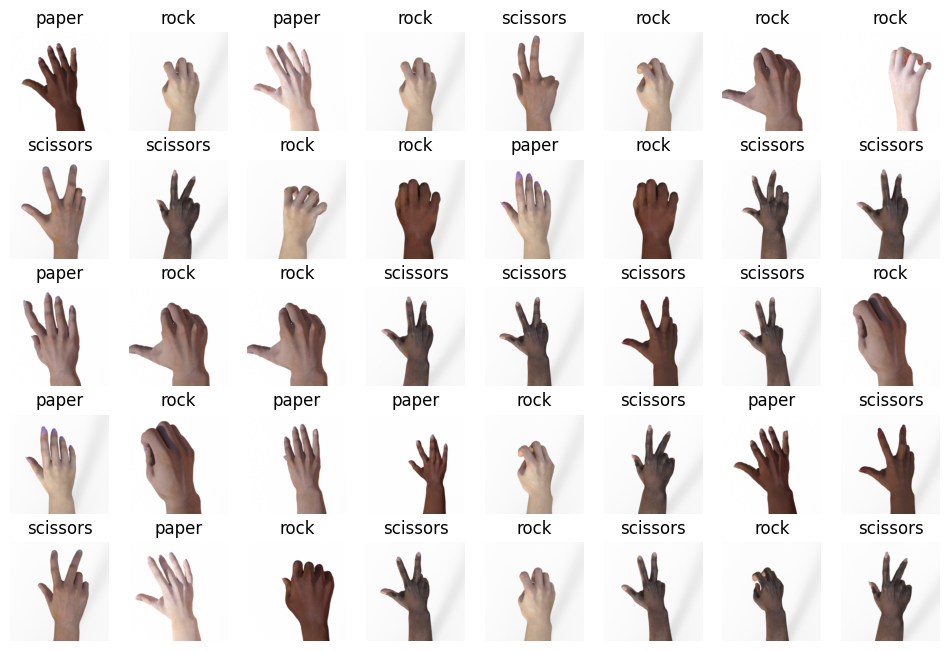

In [21]:
# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in image_folder.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

# torchvision.transform을 활용한 이미지 정규화

torchvision의 transform으로 이미지 정규화하기(평균, 표준편차를 계산하여 적용)

# CIFAR 데이터셋

In [22]:
# datasets의 CIFAR10 데이터셋 로드 (train 데이터셋)
train = datasets.CIFAR10(root='data',
                         train=True,
                         download=True,
                         # transform 지정
                         transform=transform
                        )

100%|██████████| 170498071/170498071 [00:03<00:00, 45354906.35it/s]


Extracting data/cifar-10-python.tar.gz to data


In [23]:
# datasets의 CIFAR10 데이터셋 로드 (test 데이터셋)
test = datasets.CIFAR10(root='data',
                        train=False,
                        download=True,
                        # transform 지정
                        transform=transform
                       )

Files already downloaded and verified


In [24]:
# 이미지의 RGB 채널별 통계량 확인 함수
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
    min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
    max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'min: {min_r, min_g, min_b}')
    print(f'max: {max_r, max_g, max_b}')
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

In [25]:
print_stats(train)
print('==='*10)
print_stats(test)

shape: (50000, 3, 32, 32)
min: (0.0, 0.0, 0.0)
max: (1.0, 1.0, 1.0)
mean: (0.49139965, 0.48215845, 0.4465309)
std: (0.060528398, 0.061124973, 0.06764512)
shape: (10000, 3, 32, 32)
min: (0.0, 0.0, 0.0)
max: (1.0, 1.0, 1.0)
mean: (0.49421427, 0.48513138, 0.45040908)
std: (0.06047972, 0.06123986, 0.06758436)


## transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 적용Permalink

transofrms.Normalize()는 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화를 진행합니다.

transofrms.Normalize((R채널 평균, G채널 평균, B채널 평균), (R채널 표준편차, G채널 표준편차, B채널 표준편차))

로 입력하여 적용할 수 있습니다.

변환 후 결과는 각 채널별 이미지 픽셀 값을 채널별 평균을 뺀 뒤 표준편차로 나누어 계산됩니다.

R 채널 예시

변환 후 결과 = (픽셀 값 - R채널 평균) / (R채널 표준편차)

transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 적용한 경우

위의 예시와 같이 transforms.ToTensor() 후 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)로 정규화를 적용하게 되면

RGB 각 채널의 픽셀 값에서 0.5를 뺀 뒤 0.5로 나누어 정규화를 진행합니다.

즉, transforms.ToTensor()가 이미지 픽셀 값의 범위를 0 ~ 1 로 조정했으므로,

최소값(=-1)은 (0 - 0.5) / 0.5 = -1, 최대값(=1) 은 (1 - 0.5) / 0.5 = 1 로 조정됩니다.

결국, 위의 예시를 적용한 결과는 -1 ~ 1 범위로 변환됩니다.

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # -1 ~ 1 사이의 범위를 가지도록 정규화
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [29]:
# datasets의 CIFAR10 데이터셋 로드 (train 데이터셋)
train = datasets.CIFAR10(root='data',
                         train=True,
                         download=True,
                         transform=transform
                        )

Files already downloaded and verified


In [30]:
# datasets의 CIFAR10 데이터셋 로드 (test 데이터셋)
test = datasets.CIFAR10(root='data',
                        train=False,
                        download=True,
                        transform=transform
                       )

Files already downloaded and verified


In [31]:
print_stats(train)
print('==='*10)
print_stats(test)

shape: (50000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.017200625, -0.035683163, -0.10693816)
std: (0.121056795, 0.122249946, 0.13529024)
shape: (10000, 3, 32, 32)
min: (-1.0, -1.0, -1.0)
max: (1.0, 1.0, 1.0)
mean: (-0.011571422, -0.029737204, -0.0991818)
std: (0.12095944, 0.12247972, 0.13516872)


transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 적용시

ImageNet이 학습한 수백만장의 이미지의 RGB 각각의 채널에 대한 평균은 0.485, 0.456, 0.406 그리고 표준편차는 0.229, 0.224, 0.225 입니다. 만약, 일반적인 조도, 각도, 배경을 포함하는 평범한 이미지의 경우는 (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)으로 정규화하는 것을 추천한다는 커뮤니티 의견이 지배적입니다.

하지만, 전혀 새로운 이미지 데이터를 학습할 경우는 이 다음 섹션에서 가지고 있는 데이터셋에 대한 평균, 표준편차를 산출하여 적용할 수 있습니다.

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [33]:
# datasets의 CIFAR10 데이터셋 로드 (train 데이터셋)
train = datasets.CIFAR10(root='data',
                         train=True,
                         download=True,
                         transform=transform
                        )
# datasets의 CIFAR10 데이터셋 로드 (test 데이터셋)
test = datasets.CIFAR10(root='data',
                        train=False,
                        download=True,
                        transform=transform
                       )

Files already downloaded and verified
Files already downloaded and verified


In [34]:
print_stats(train)
print('==='*10)
print_stats(test)

shape: (50000, 3, 32, 32)
min: (-2.117904, -2.0357141, -1.8044444)
max: (2.2489083, 2.4285715, 2.64)
mean: (0.027946174, 0.116778664, 0.1801375)
std: (0.2643161, 0.27287933, 0.30064496)
shape: (10000, 3, 32, 32)
min: (-2.117904, -2.0357141, -1.8044444)
max: (2.2489083, 2.4285715, 2.64)
mean: (0.04023701, 0.1300509, 0.19737385)
std: (0.26410356, 0.27339223, 0.30037493)


데이터셋의 평균(mean)과 표준편차(std)를 계산하여 적용시

학습할 이미지 데이터셋이 일반적인 조도, 각도, 배경, 사물체가 아닌 경우는 직접 평균/표준편차를 계산하여 적용할 수 있습니다.  
아래 함수는 이미지 데이터셋에 대하여 평균, 표준편차를 산출해 주는 함수 입니다.

In [35]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()

    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [36]:
# 먼저, 변환하기 전 이미지 데이터셋을 로드 하기 위하여 transforms.ToTensor() 만 적용합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [37]:
# datasets의 CIFAR10 데이터셋 로드 (train 데이터셋)
train = datasets.CIFAR10(root='data',
                         train=True,
                         download=True,
                         transform=transform
                        )

Files already downloaded and verified


In [38]:
mean_, std_ = calculate_norm(train)
print(f'평균(R,G,B): {mean_}\n표준편차(R,G,B): {std_}')

평균(R,G,B): (0.49139965, 0.48215845, 0.4465309)
표준편차(R,G,B): (0.20220213, 0.19931543, 0.20086348)


이제 계산된 평균과 표준편차를 적용하여 변환합니다.

In [39]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_, std_),
])

In [40]:
# datasets의 CIFAR10 데이터셋 로드 (train 데이터셋)
train = datasets.CIFAR10(root='data',
                         train=True,
                         download=True,
                         transform=transform
                        )

Files already downloaded and verified


In [41]:
# datasets의 CIFAR10 데이터셋 로드 (test 데이터셋)
test = datasets.CIFAR10(root='data',
                        train=False,
                        download=True,
                        transform=transform
                       )

Files already downloaded and verified


In [42]:
print_stats(train)
print('==='*10)
print_stats(test)

shape: (50000, 3, 32, 32)
min: (-2.4302397, -2.4190724, -2.2230568)
max: (2.5153067, 2.598101, 2.7554488)
mean: (2.0912171e-07, -1.5499116e-07, 8.5353854e-08)
std: (0.299346, 0.30667457, 0.3367716)
shape: (10000, 3, 32, 32)
min: (-2.4302397, -2.4190724, -2.2230568)
max: (2.5153067, 2.598101, 2.7554488)
mean: (0.01391995, 0.014915802, 0.019307619)
std: (0.29910526, 0.307251, 0.33646908)


변환된 통계량을 보면, train 셋의 평균은 거의 (0, 0, 0)에 수렴하는 것을 확인할 수 있습니다. (이는 train 셋을 기준으로 변환했기 때문입니다.)